In [12]:
# Import libraries
import pandas as pd
import numpy as np
import math
import csv
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
# Read in full Motor Vehicle Collision Dataset
mvc_df = pd.read_csv('Motor_Vehicle_Collisions_-_Crashes.csv')

C:\Users\nedko\AppData\Local\Temp\ipykernel_3920\3333524029.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  mvc_df = pd.read_csv('Motor_Vehicle_Collisions_-_Crashes.csv')


In [3]:
mvc_df.head()

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
0,09/11/2021,2:39,NaN,NaN,NaN,NaN,NaN,WHITESTONE EXPRESSWAY,20 AVENUE,NaN,...,Unspecified,NaN,NaN,NaN,4455765,Sedan,Sedan,NaN,NaN,NaN
1,03/26/2022,11:45,NaN,NaN,NaN,NaN,NaN,QUEENSBORO BRIDGE UPPER,NaN,NaN,...,NaN,NaN,NaN,NaN,4513547,Sedan,NaN,NaN,NaN,NaN
2,06/29/2022,6:55,NaN,NaN,NaN,NaN,NaN,THROGS NECK BRIDGE,NaN,NaN,...,Unspecified,NaN,NaN,NaN,4541903,Sedan,Pick-up Truck,NaN,NaN,NaN
3,09/11/2021,9:35,BROOKLYN,11208.0,40.667202,-73.866500,"(40.667202, -73.8665)",NaN,NaN,1211 LORING AVENUE,...,NaN,NaN,NaN,NaN,4456314,Sedan,NaN,NaN,NaN,NaN
4,12/14/2021,8:13,BROOKLYN,11233.0,40.683304,-73.917274,"(40.683304, -73.917274)",SARATOGA AVENUE,DECATUR STREET,NaN,...,NaN,NaN,NaN,NaN,4486609,NaN,NaN,NaN,NaN,NaN


In [8]:
mvc_df['year'] = mvc_df['CRASH DATE'].apply(lambda x: datetime.strptime(x, '%m/%d/%Y').year)
mvc_df['year'].value_counts()                                      

2018    231564
2017    231007
2016    229831
2015    217694
2019    211486
2014    206033
2013    203740
2020    112916
2021    110548
2022    103870
2012    100545
2023     67413
Name: year, dtype: int64

In [14]:
accident_causes = mvc_df['CONTRIBUTING FACTOR VEHICLE 1'].value_counts()


[]

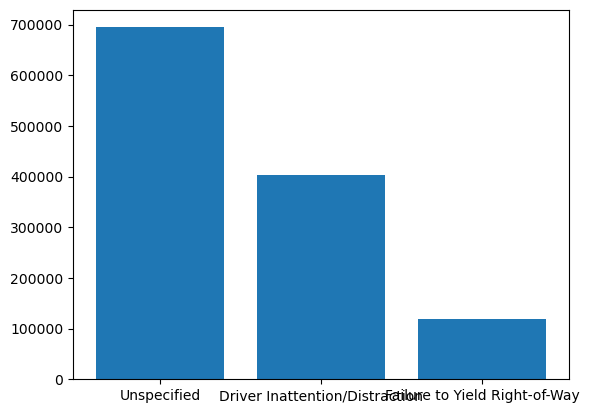

In [28]:

plt.bar(accident_causes.head(3).index, accident_causes.head(3).values)
plt.plot()

In [ ]:
def find_cause(cause1, cause2, cause3, cause4, cause5):
    if('alcohol' in cause1.lower() or 'alcohol' in cause2.lower() or 'alcohol' in cause3.lower() or 'alcohol' in cause4.lower() or 'alcohol' in cause5.lower()):
        return 'Drunk Driving'
    if('speed' in cause1.lower() or 'speed' in cause2.lower() or 'speed' in cause3.lower() or 'speed' in cause4.lower() or 'speed' in cause5.lower()):
        return 'Speeding'
    if('drugs' in cause1.lower() or 'drugs' in cause2.lower() or 'drugs' in cause3.lower() or 'drugs' in cause4.lower() or 'drugs' in cause5.lower()):
        return 'Drugged Driving'
    if('phone' in cause1.lower() or 'phone' in cause2.lower() or 'phone' in cause3.lower() or 'phone' in cause4.lower() or 'phone' in cause5.lower()):
        return 'Cell Phone Usage'
    if('texting' in cause1.lower() or 'texting' in cause2.lower() or 'texting' in cause3.lower() or 'texting' in cause4.lower() or 'texting' in cause5.lower()):
        return 'Cell Phone Usage'